**READ DATA** 

In [1]:
import pandas as pd
bike_rentals = pd.read_csv("hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [2]:
bike_rentals.shape

(17379, 17)

Here are the descriptions for the relevant columns:

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered



**We'll try to predict the total number of bikes people rented in a given hour. We'll predict the cnt column using all of the other columns, except for casual and registered.**

#### Distribution of total rentals

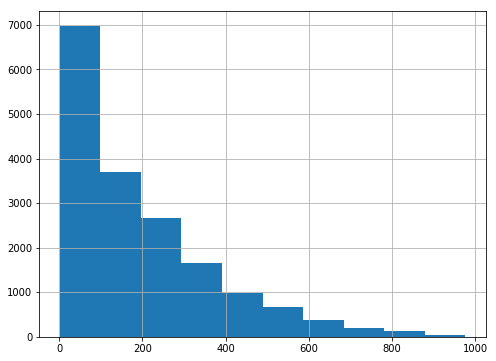

In [3]:

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.hist(bike_rentals["cnt"])
plt.grid(True)
plt.show()

#### How each column is correlated with cnt

In [4]:
bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

#### We can introduce some order into the process by creating a new column with labels for morning(1), afternoon(2), evening(3), and night(4). This will bundle similar times together, enabling the model to make better decisions.

In [5]:
def assign_label(hour):
    if 6 <= hour < 12:
        return 1
    if 12 <= hour < 18:
        return 2
    if 18 <= hour < 24:
        return 3
    if 0 <= hour < 6:
        return 4
    
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

bike_rentals.head()
    

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

####  Split the data into training and testing sets. This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set.

In [6]:
train = bike_rentals.sample(frac=0.8) # Select 80% of the rows in bike_rentals to be part of the training set using the sample method on bike_rentals
train.shape

(13903, 18)

In [7]:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)] #Select the rows that are in bike_rentals but not in train to be in the testing set.
test.shape

(3476, 18)

In [8]:
bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
time_label   -0.378318
Name: cnt, dtype: float64

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy
columns = list(train.columns)
columns.remove("cnt")
columns.remove("casual")
columns.remove("registered")
columns.remove("dteday")

lr = LinearRegression()
lr.fit(train[columns],train["cnt"])
prediction = lr.predict(test[columns])
mse = mean_squared_error(prediction,test["cnt"]) #numpy.mean((prediction - test["cnt"]) ** 2)

print("mean squared error",mse)



mean squared error 18081.9999114


In [24]:
prediction

array([-115.45877658,   89.29728883,  136.16741996, ...,  198.34574896,
        210.02705365,  182.0391189 ])

In [25]:
test["cnt"]

0         16
8          8
14       106
15       110
18        35
20        36
27         6
31         8
38        74
39        76
42        30
56        51
59        77
62       157
64       110
68        12
88        54
102       46
103       79
114       19
117        2
119        4
122      219
124       45
130       86
132      163
144       84
148       67
151       50
152       72
        ... 
17258     10
17259      3
17262      1
17263      3
17268    133
17270    103
17275    174
17287      4
17292    191
17302    128
17303     97
17311      3
17312      3
17313      7
17322    129
17323    147
17328     60
17329     54
17336      2
17340     74
17344    169
17345    160
17346    138
17348    123
17350    102
17357     11
17364    157
17371    214
17372    164
17378     49
Name: cnt, Length: 3476, dtype: int64

### Error
The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors lead to a higher total error.

In [30]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(random_state=1)
reg.fit(train[columns],train["cnt"])
prediction_dec = reg.predict(test[columns])
mse_dec = mean_squared_error(prediction_dec,test["cnt"])

mse_dec

3398.5186996547754

In [31]:
prediction_dec

array([  39.,   14.,   75., ...,  133.,   93.,   59.])

In [32]:
reg = DecisionTreeRegressor(random_state=1,min_samples_leaf=2)
reg.fit(train[columns],train["cnt"])
prediction_dec = reg.predict(test[columns])
mse_dec = mean_squared_error(prediction_dec,test["cnt"])

mse_dec

3072.8199878532159

In [40]:
reg = DecisionTreeRegressor(random_state=1,min_samples_leaf=6)
reg.fit(train[columns],train["cnt"])
prediction_dec = reg.predict(test[columns])
mse_dec = mean_squared_error(prediction_dec,test["cnt"])

mse_dec

2442.0285068198878

In [50]:
reg = DecisionTreeRegressor(random_state=1,min_samples_split=10)
reg.fit(train[columns],train["cnt"])
prediction_dec = reg.predict(test[columns])
mse_dec = mean_squared_error(prediction_dec,test["cnt"])

mse_dec

2870.8495421642479

#### Decision tree error

By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

In [59]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor( min_samples_leaf=5)
rf.fit(train[columns],train["cnt"])
prediction_rf = rf.predict(test[columns])
mse_rf = mean_squared_error(prediction_rf,test["cnt"])

mse_rf


1924.535410047479

In [61]:
rf = RandomForestRegressor(n_estimators=150, random_state=1, min_samples_leaf=2)
rf.fit(train[columns],train["cnt"])
prediction_rf = rf.predict(test[columns])
mse_rf = mean_squared_error(prediction_rf,test["cnt"])

mse_rf

1645.4515978724717

#### Random forest error
 
By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.

In [76]:
print(test["cnt"][0:10])
prediction_rf[0:10]

0      16
8       8
14    106
15    110
18     35
20     36
27      6
31      8
38     74
39     76
Name: cnt, dtype: int64


array([  35.04747619,   22.42996825,  115.86933333,   88.74962698,
         82.94851058,   53.78407143,   17.72122222,   38.82528571,
         65.10000794,   87.99081746])

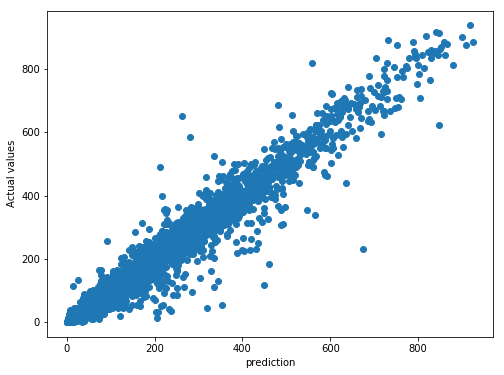

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(prediction_rf,test["cnt"])
plt.xlabel("prediction")
plt.ylabel("Actual values")
plt.show()